#### TODO:

Train&Test
- split the dataset into train and test
- drop the lables that are not working!

Inputs&Labels
- mix the labels and input orders (all of them are [0,1])
- Deal with the labels and inputes 

Articles&Tenses
- Remove the articles and present tense verbs

## Imports

In [103]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import ast
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from lambeq.backend.grammar import Ty, Box 
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter


print("(*) All libraries are successfully imported!\n")

(*) All libraries are successfully imported!



## Dataset

Split the dataset and label into trainign and testing similar to the pennyland model

In [104]:
# ==============================================
# ==============================================

# Read the CSV file
file_path = os.path.join(os.getcwd(), "features_dataset.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_1 = df['image_1']
image_2 = df['image_2']
label_image1 = df['label_image1']
label_image2 = df['label_image2']

df = pd.DataFrame({
    'sentence': sentence,
    'image_1': image_1,
    'image_2': image_2,
    'label_image1': label_image1,
    'label_image2': label_image2
})

# Make the image_1 and image_2 into float lists instead of strings
df["image_1"] = df["image_1"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["image_2"] = df["image_2"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ============= TODO: =============
# RE ORDER THE LABELS AND IMAGES!
# =================================

# First split: train and combined validation/test set
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: validation and test set
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print the sizes of each set to verify
print(f" Training set size: {len(train_df)}")
print(f" Validation set size: {len(val_df)}")
print(f" Test set size: {len(test_df)}")



print("(*) Data Extracted!\n")

 Training set size: 142
 Validation set size: 31
 Test set size: 31
(*) Data Extracted!



## Sentences Diagram & Circuit

 parsing sentences ..
 ↓ example senetnce diagram from train dataset


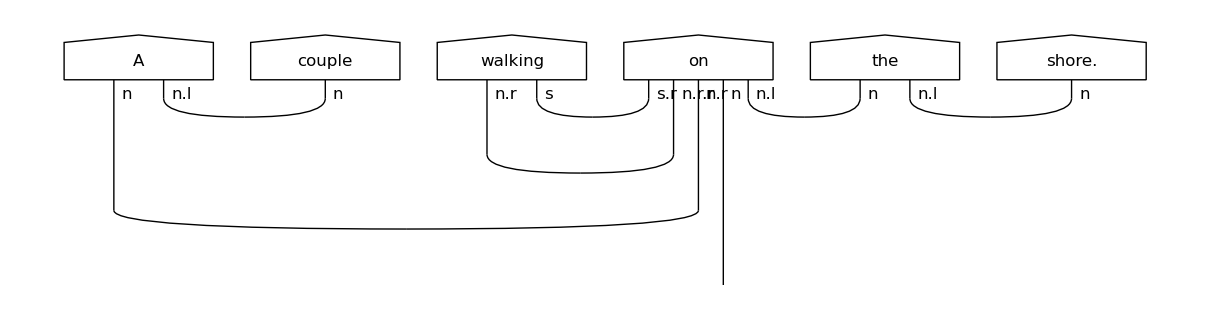

 creating diagrams ..
 ↓ sample sentence diagram without cups from train dataset


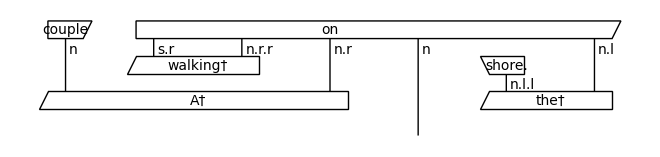

 ↓ sample sentence circuit from train dataset


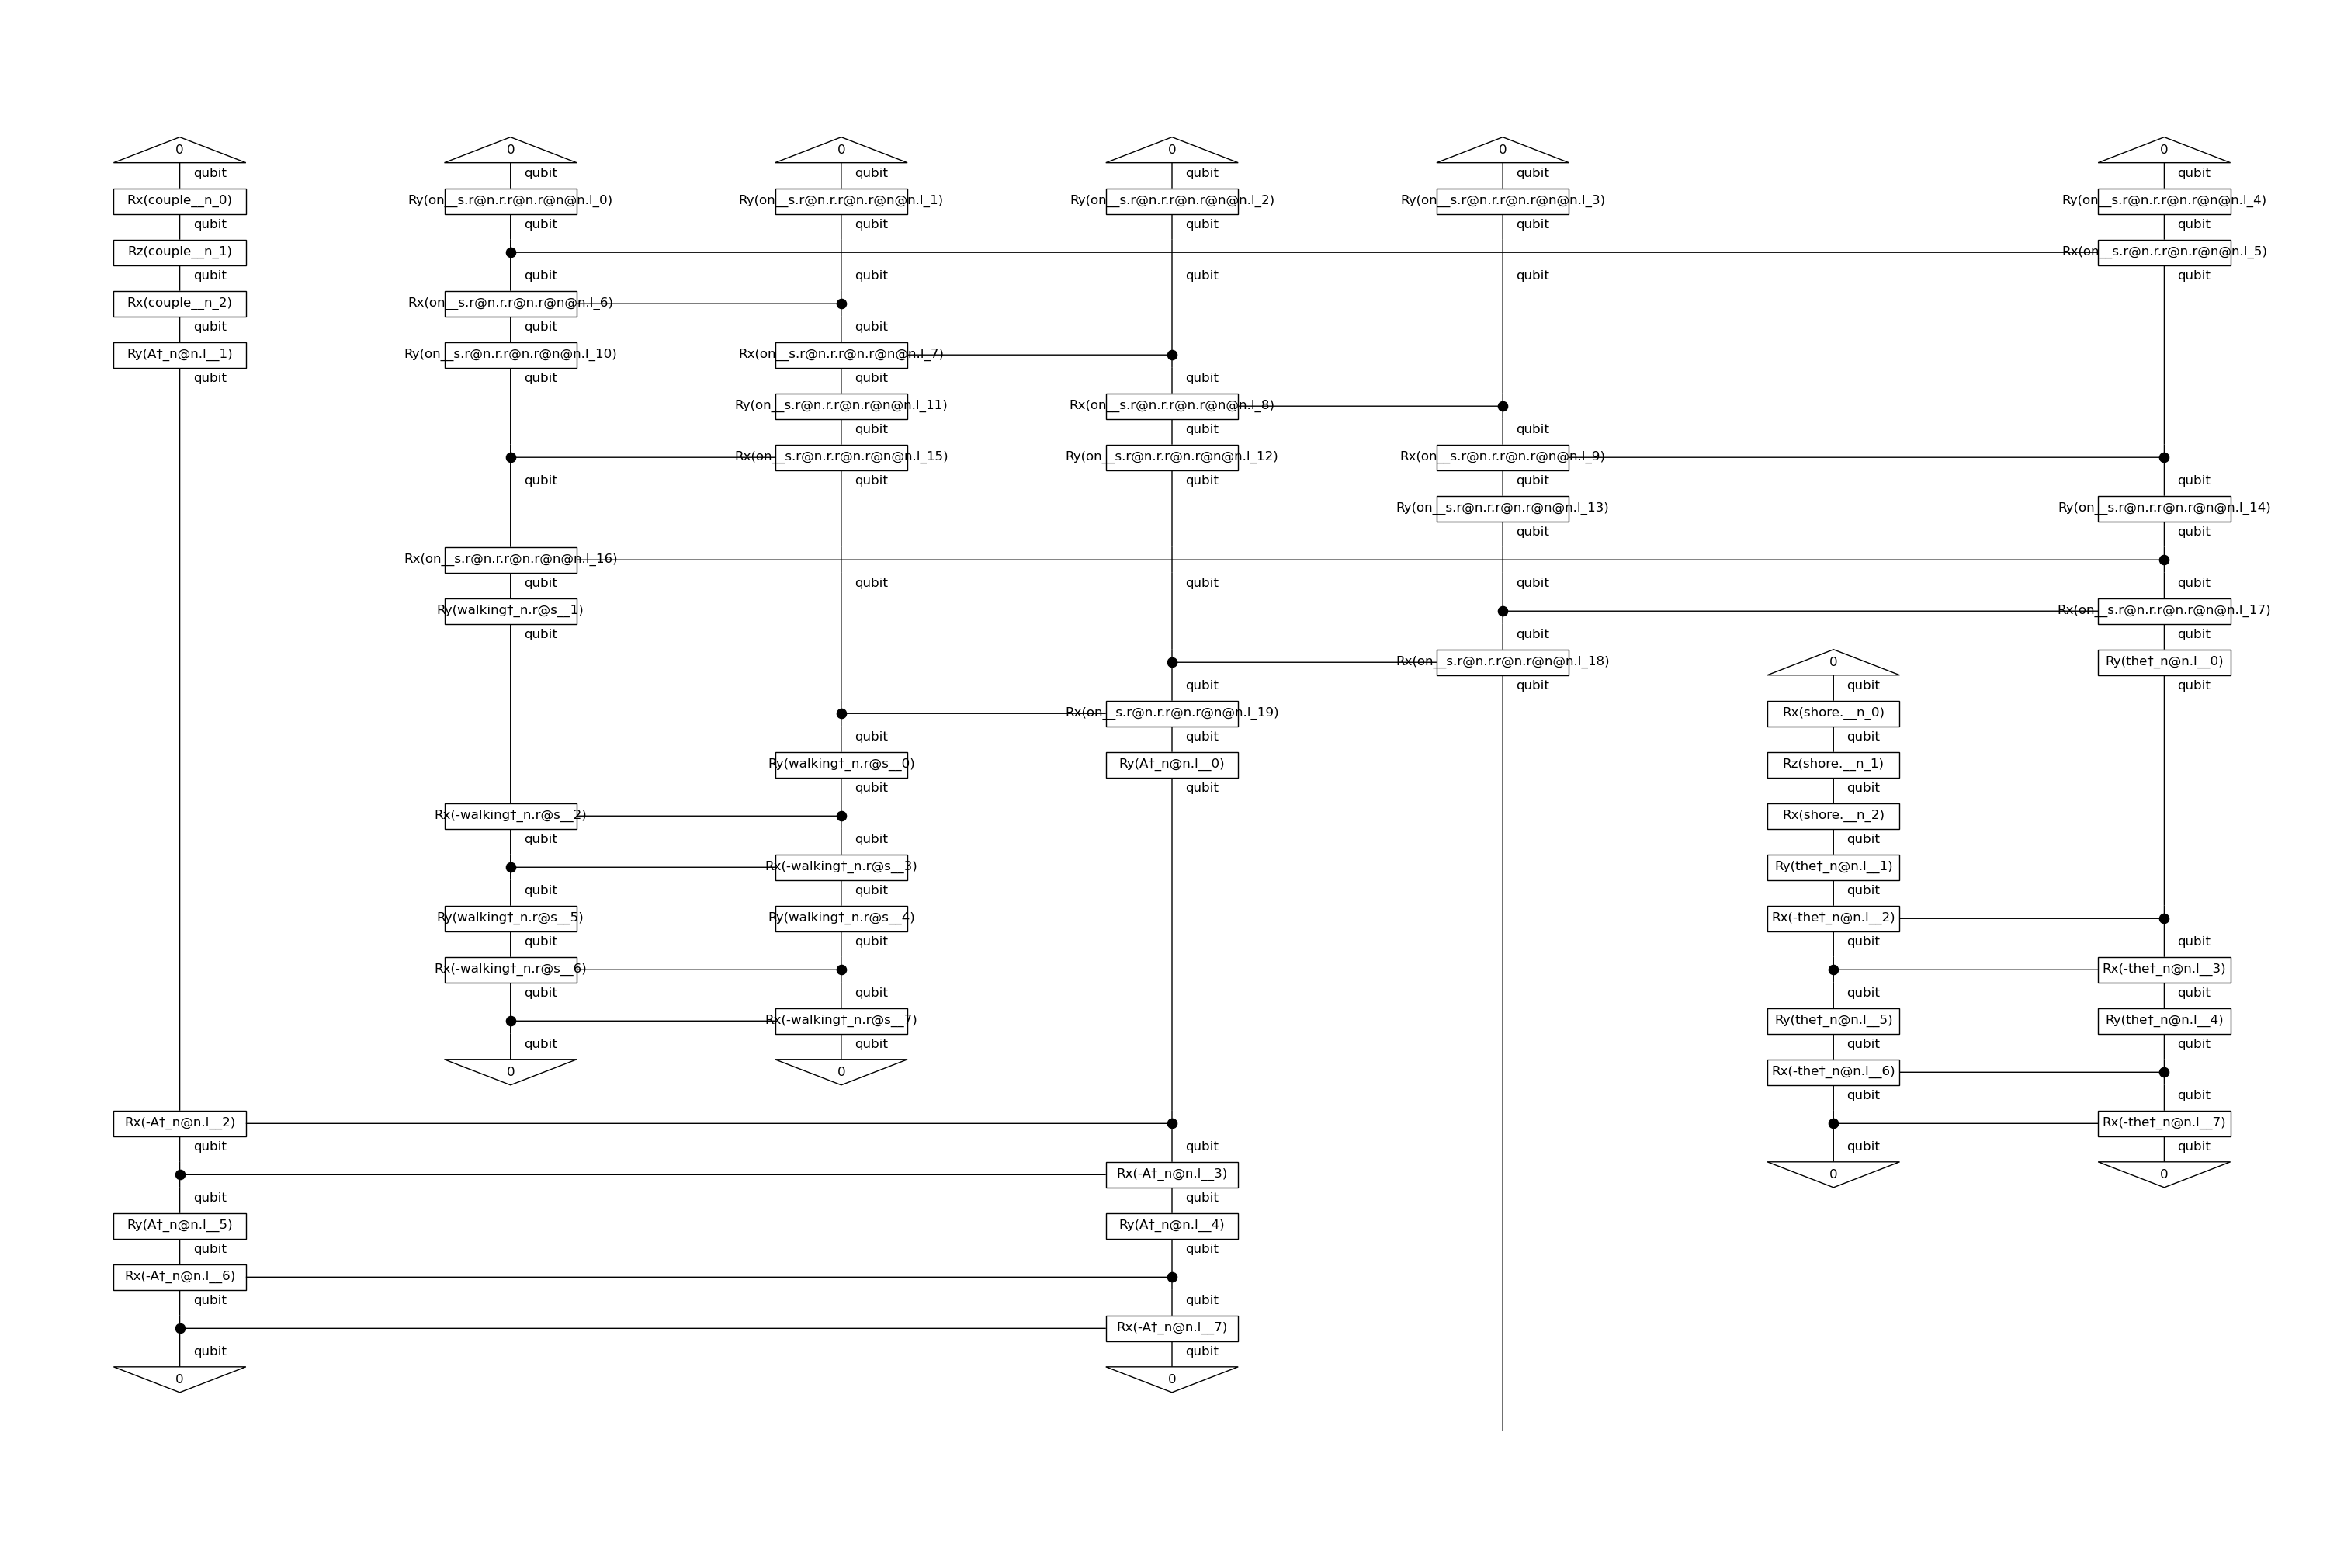

(*) Ansatz created for all senetnces!



In [105]:
# ==============================================
# CREATE SENTENCE DIAGRAMS
# ==============================================

remove_cups = RemoveCupsRewriter()

# Parse the sentence 
train_sentences = train_df["sentence"]
val_sentences = val_df["sentence"]
test_sentences = test_df["sentence"]

# Use BobbcatParser to convert it into a string diagram
print(" parsing sentences ..")
parser = BobcatParser(verbose='suppress')
raw_train_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in train_sentences]
raw_val_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in val_sentences]
raw_test_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in test_sentences]
# --------
print(" ↓ example senetnce diagram from train dataset")
raw_train_sentence_diagrams[1].draw(figsize=(14, 3), fontsize=12)
# --------

# Use remove cups to decrease the number of wires used
print(" creating diagrams ..")
train_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_train_sentence_diagrams]
val_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_val_sentence_diagrams]
test_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_test_sentence_diagrams]
# --------
print(' ↓ sample sentence diagram without cups from train dataset')
train_diagrams_sentence[1].draw()
# --------

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},n_layers=1)

train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]
val_circuits_sentence = [ansatz_sentence(diagram) for diagram in val_diagrams_sentence]
test_circuits_sentence = [ansatz_sentence(diagram) for diagram in test_diagrams_sentence]
# --------
print(' ↓ sample sentence circuit from train dataset')
train_circuits_sentence[1].draw(figsize=(30, 20), fontsize=12)
# --------

print("(*) Ansatz created for all senetnces!\n")

## Image Diagram & Circuit

 Complete: circuits for positive image
 ↓ sample sentence diagram without cups from train dataset


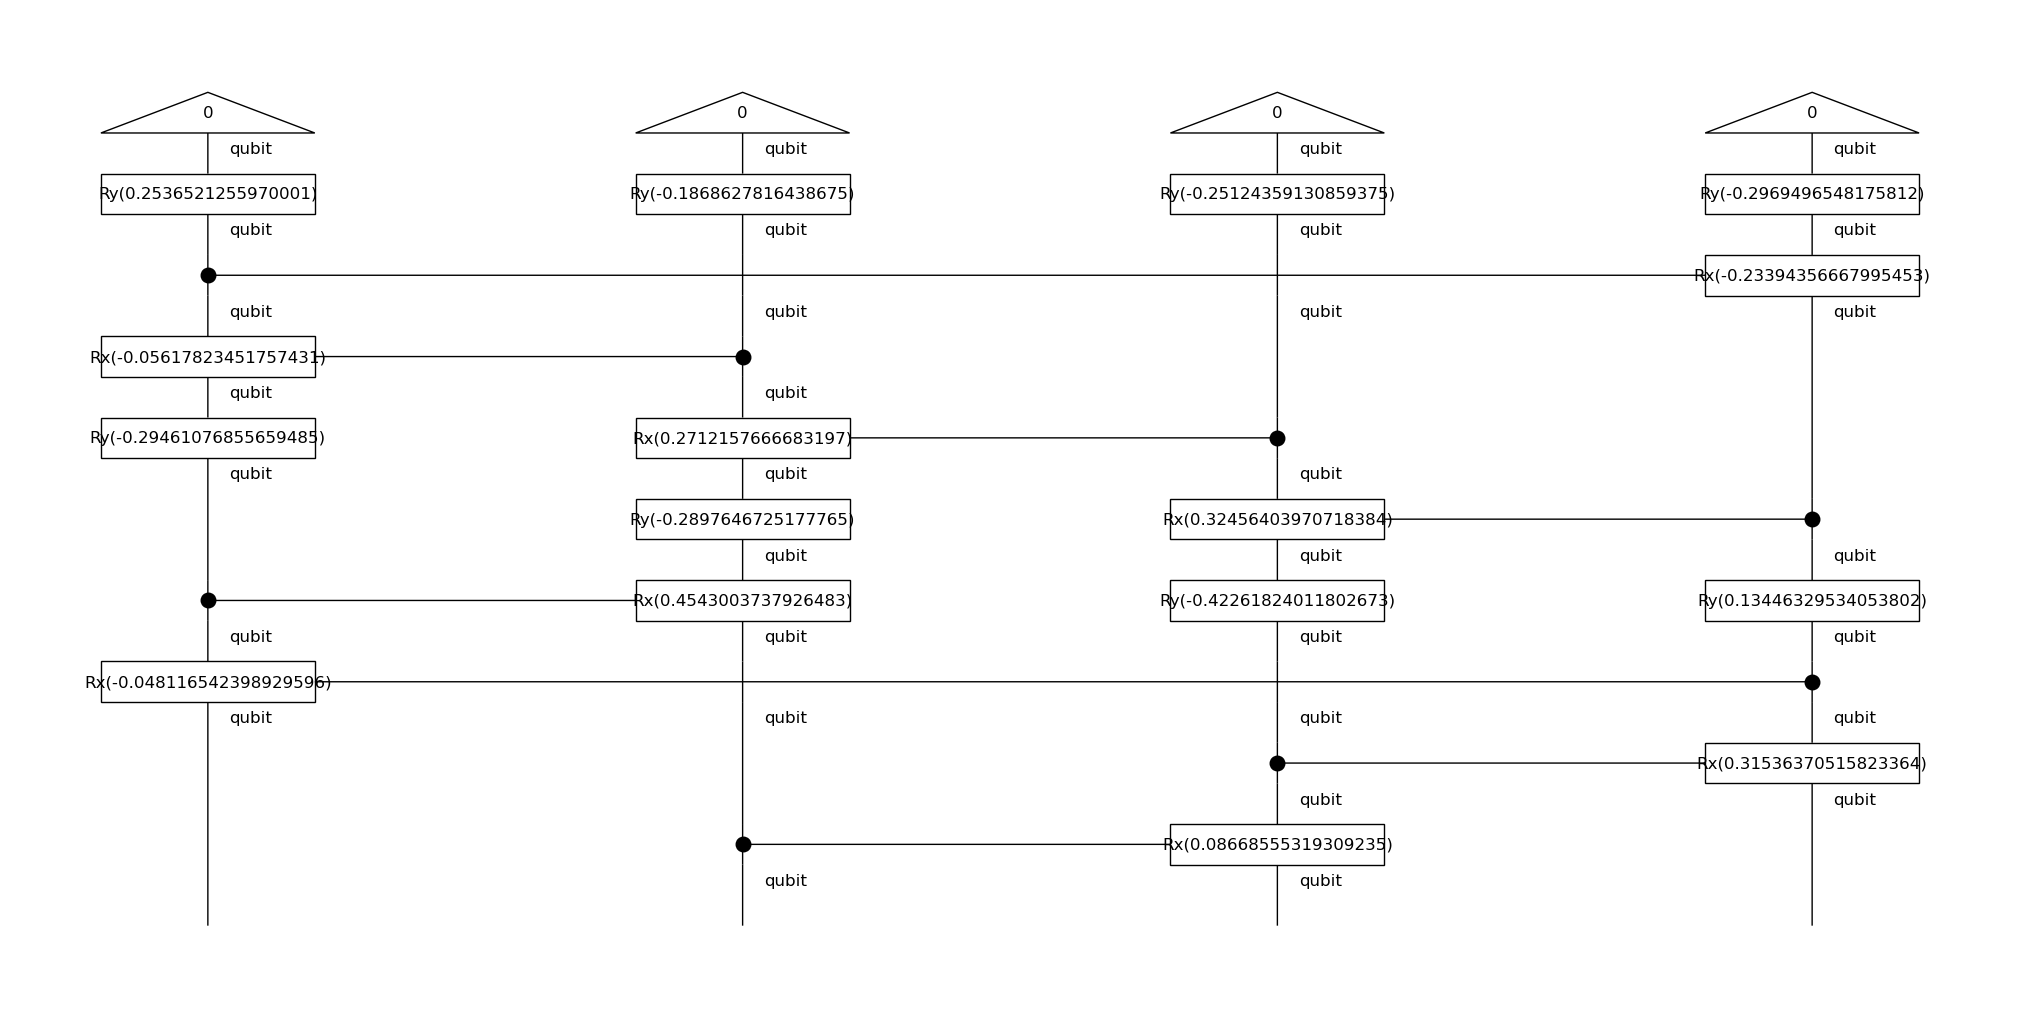

 Complete: circuit for negative images


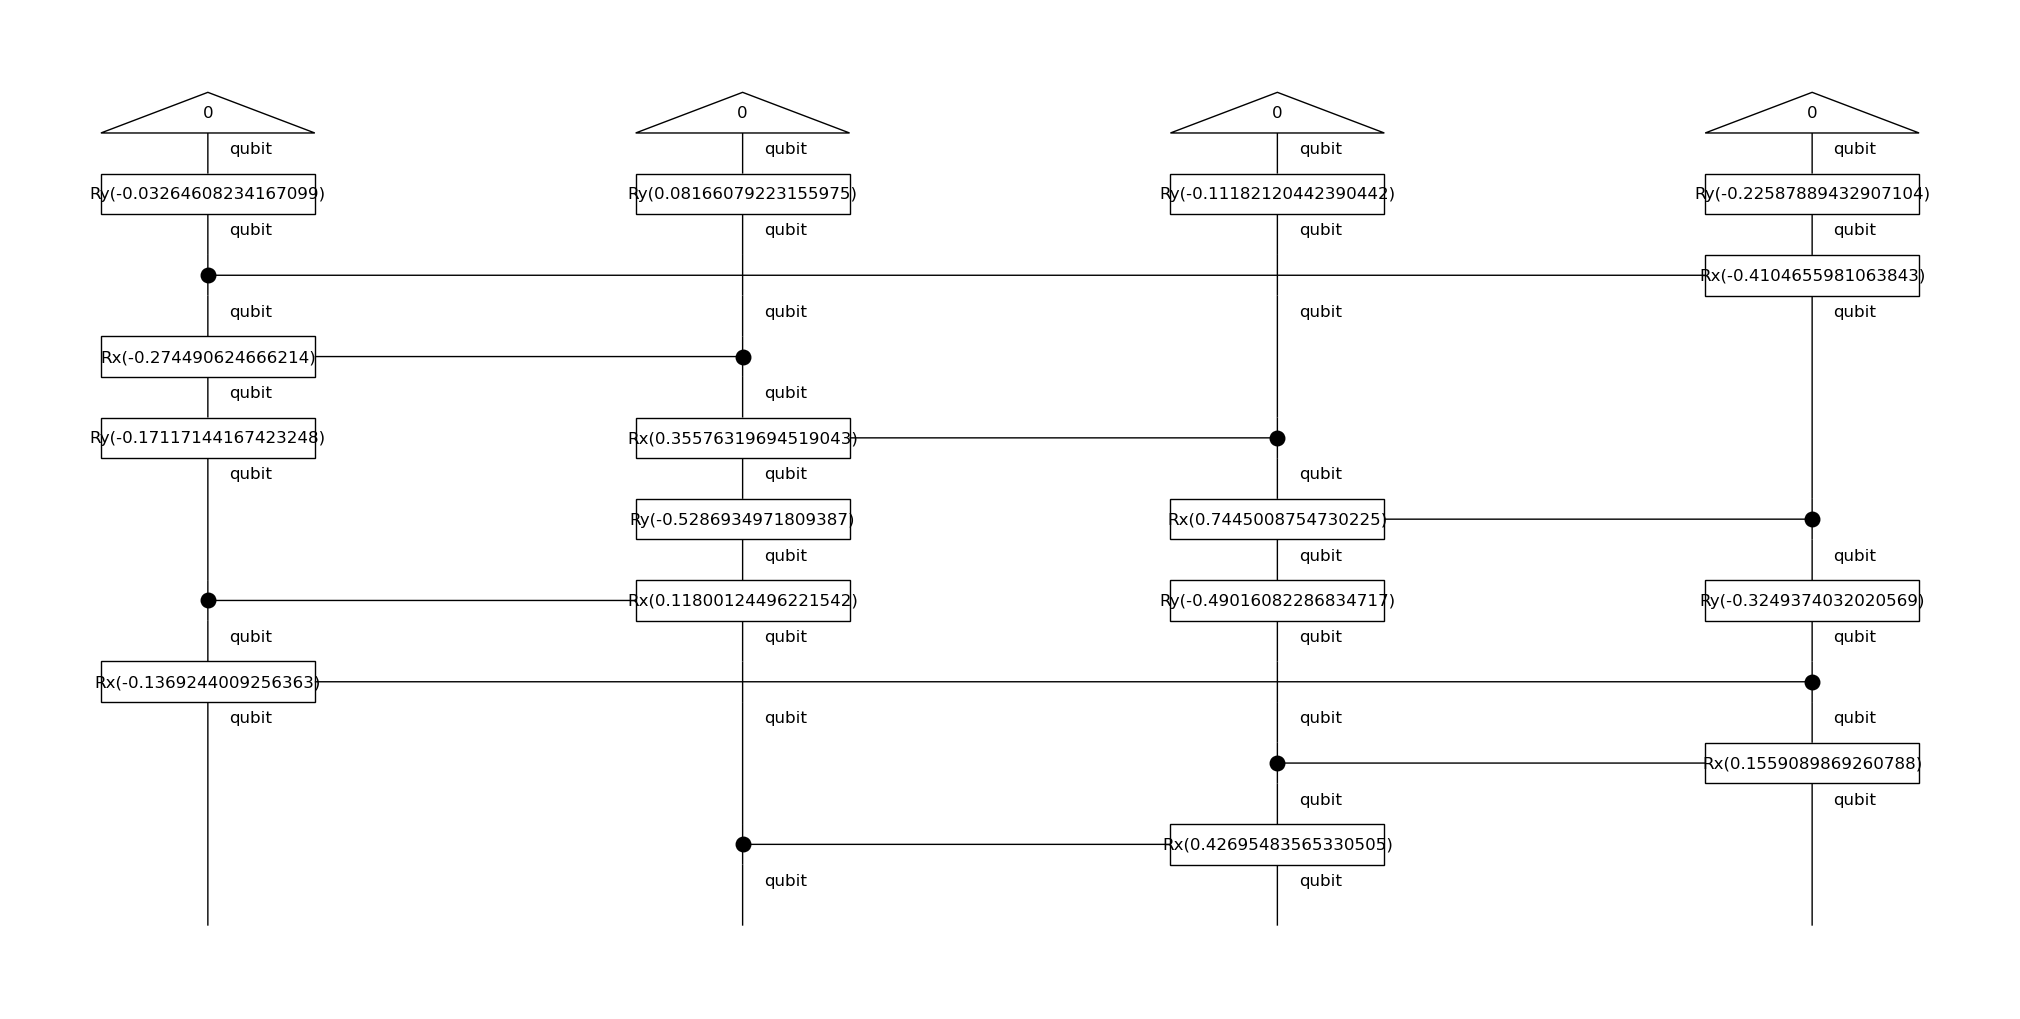

(*) Circuits and digrams created for all images!



In [106]:
# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
# image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
# print('↓ template image circuit')
# image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POSITIVE
train_images_1 = train_df["image_1"]
val_images_1 = val_df["image_1"]
test_images_1 = test_df["image_1"]

train_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_1]
val_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_1]
test_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_1]
print(" Complete: circuits for positive image")
#  --------
print(' ↓ sample sentence diagram without cups from train dataset')
train_circuits_image1[1].draw(figsize=(20, 10), fontsize=12)
#  --------

# Add data into image circuit NEGATIVE
train_images_2 = train_df["image_2"]
val_images_2 = val_df["image_2"]
test_images_2 = test_df["image_2"]

train_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_2]
val_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_2]
test_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_2]
print(" Complete: circuit for negative images")
#  --------
train_circuits_image2[1].draw(figsize=(20, 10), fontsize=12)
#  --------

print("(*) Circuits and digrams created for all images!\n")

## Combined for Sentence & Images:

#### Diagram template 

************************
Error at index in diagram sentence 1: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     A person stands by a lake.
Error at index in diagram sentence 15: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     A woman plays ball in the pool.
Error at index in diagram sentence 27: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     A man runs through water.
Error at index in diagram sentence 45: Diagram 0 (cod=n.r @ s @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     A boy runs near the sea.
Error at index in diagram sentence 47: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     A girl walks down the road.
Error at index in diagram sentence 54: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
     Girl is standing in the gras

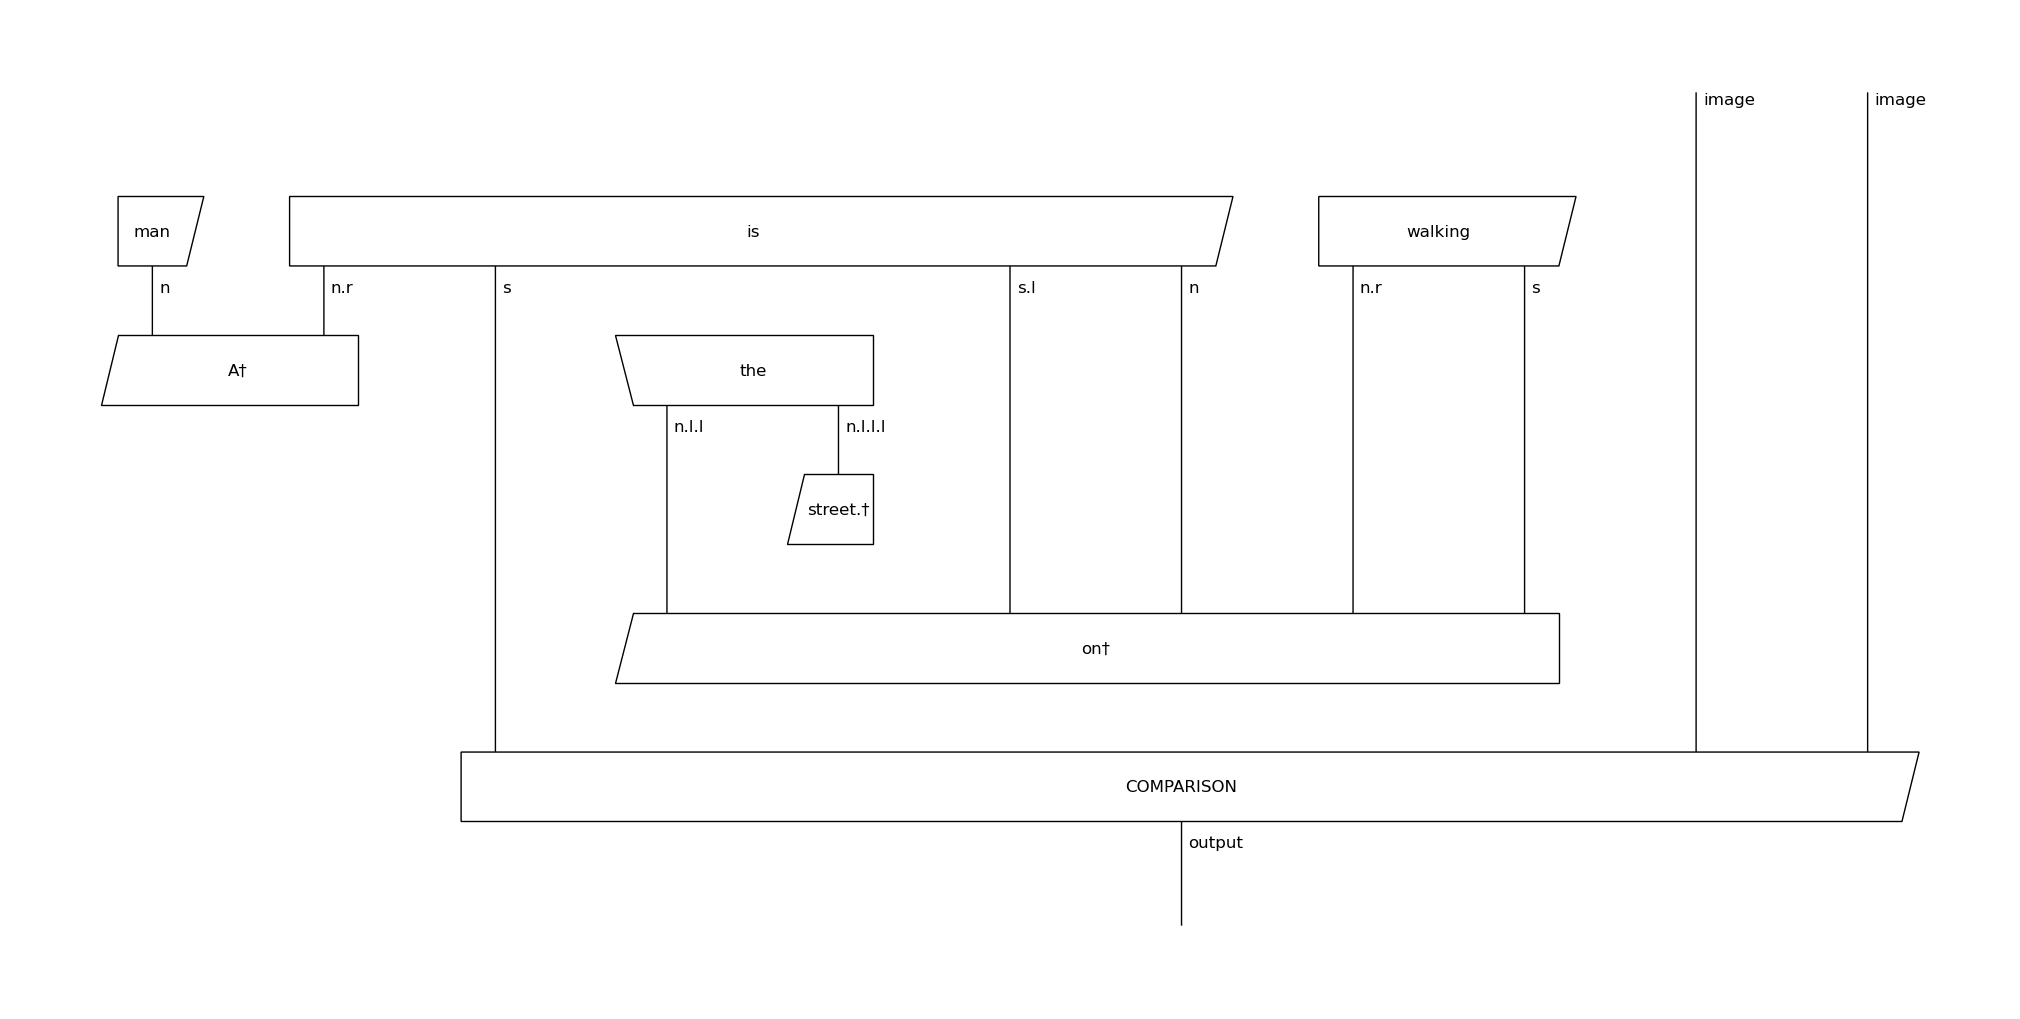



(*) Train: 92 diagrams completed successfully!


(*) Val:25 diagrams completed successfully!


(*) Test: 31 diagrams completed successfully!



In [109]:
# CREATE FINAL CIRCUIT

# Create new Type
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1) - Sentence digram and comparison box is in grammar form

# Create a list of indicies to drop
# Drop indicies that do not work
# iterate do the @@>> part in a for loop

def generate_valid_diagrams(diagram_sentence, df):
    print("************************")
    indicies_to_drop= []
    conc_diagrams = []
    for index, row in df.iterrows():
        try:
            temp = diagram_sentence[index] @ image_type @ image_type >> comparison_box
            conc_diagrams.append(temp)
        except Exception as e:
            print(f"Error at index in diagram sentence {index}: {e}")
            print( "    ",df["sentence"].iloc[index])
            indicies_to_drop.append(index)
    print("************************")

    # print("************************")
    for index, row in df.iterrows():
        if index in indicies_to_drop:
            # print("Removing index: ", index)
            df = df.drop(index = index)
    # print("************************")

    print("Dropped the following indicies:", indicies_to_drop)
    
    return df, conc_diagrams

train_df, train_conc_diagrams = generate_valid_diagrams(train_diagrams_sentence, train_df)
val_df, val_conc_diagrams = generate_valid_diagrams(val_diagrams_sentence, val_df)
test_df, test_conc_diagrams = generate_valid_diagrams(test_diagrams_sentence, test_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("CHCEKING:")
print(f"{len(train_df)} == {len(train_conc_diagrams)}")
print(f"{len(val_df)} == {len(val_conc_diagrams)}")
print(f"{len(test_df)} == {len(test_conc_diagrams)}")

# conc_diagrams = []
# print("NOTE: diagrams that cause an error are not added to the list")
# print(" this is an error due to miscalculation from lambeq")
# print("=======================")
# for num in range(len(df)):
#     try:
#         temp = train_diagrams_sentence[num] @ image_type @ image_type >> comparison_box
#         conc_diagrams.append(temp)
#     except Exception as e:
#         print(f"Error at index {num}: {e}")
# print("=======================")

# train_conc_diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in train_diagrams_sentence]
# val_conc_diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in val_diagrams_sentence]
# test_conc_diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in test_diagrams_sentence]

print(' ↓ template merged diagram : (sentence, image1, image2)')
train_conc_diagrams[18].draw(figsize=(20, 10), fontsize=12)


print("")
print(f"\n(*) Train: {len(train_conc_diagrams)} diagrams completed successfully!\n")
print(f"\n(*) Val:{len(val_conc_diagrams)} diagrams completed successfully!\n")
print(f"\n(*) Test: {len(test_conc_diagrams)} diagrams completed successfully!\n")



#### Circuit Template

In [ ]:
# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)

print("NOTE: ansatz that cause an error are not added to the list")
print(" this is due to a prepositional phrase found in the sentence")
conc_circuit = []
print("=======================")
for num in range(len(conc_diagrams)):
    try:
        temp = ansatz(conc_diagrams[num])
        conc_circuit.append(temp)
    except Exception as e:
        print(f"Error at index {num}: {e}")
print("=======================")

print(f"\n(*) {len(conc_circuit)} / {len(conc_diagrams)} / {len(df)} diagrams completed successfully!\n")

# temp_circuit = [ansatz(diagram) for diagram in conc_diagrams]
print(" ↓ template circuit : (sentence, image_type , image_type)")
conc_circuit[0].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )



#### Final Circuit 

In [ ]:
# final_circuit = image_1 @ image_2 >> temp_circuit

final_circuit = [(train_circuits_image1[index] @ train_circuits_image2[index] >> conc_circuit[index]) for index in range(len(conc_circuit))]

print("  ↓ sample quantum circuit : (sentence, image data pos , image data neg)")
final_circuit[].draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )
